In [24]:
from __future__ import division,absolute_import, print_function, unicode_literals

import skimage
from skimage.transform import  resize

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
from subprocess import call
import math
from tensorflow.core.protobuf import saver_pb2
import driving_data
import model
import tensorflow as tf
import scipy
import scipy.misc
import random
import numpy as np
from scipy import pi
from itertools import islice

import os
os.chdir('C:/Users/keert/Assignments/Assignment28')

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# read images and steering angles from driving_dataset folder
DATA_FOLDER = './driving_dataset/' # change this to your folder
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')


split =0.7 #This is giving the 80% Train and 20% Test Data Split
X = []
y = []
with open(TRAIN_FILE) as fp: #Reading tre file
    for line in islice(fp,None):
        path, angle = line.strip().split()  #Reading the path and angle
        full_path = os.path.join(DATA_FOLDER, path)
        X.append(full_path)
        
        # converting angle from degrees to radians
        y.append(float(angle) * pi / 180 )


y = np.array(y)
print("Completed processing data.txt")

# Now split the angles into train_y and test_y
split_index = int(len(y)*split)

train_y = y[:split_index] #First 80%
test_y = y[split_index:] # Last 20%

Completed processing data.txt


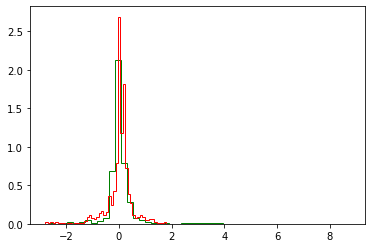

In [4]:
import numpy;

# PDF of train and test 'y' values. 
import matplotlib.pyplot as plt 
%matplotlib inline
plt.hist(train_y, bins=50, normed=1, color='green', histtype ='step');
plt.hist(test_y, bins=50, normed=1, color='red', histtype ='step');
plt.show()

In [5]:
xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open("driving_dataset/data.txt") as f:
    for line in f:
        #We split the text data(data.txt file) and line.split()[0] will give inage name , line.split()[1] gives angles
        xs.append("driving_dataset/" + line.split()[0]) #xs contains the path to the images.
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180) #ys contains the angles in radians

#get number of images
num_images = len(xs)

In [6]:

#Temporal split
train_xs = xs[:int(len(xs) * 0.7)] 
train_ys = ys[:int(len(xs) * 0.7)]

val_xs = xs[-int(len(xs) * 0.3):]
val_ys = ys[-int(len(xs) * 0.3):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

In [16]:
# This function loads batch of images from training data
def LoadTrainBatch(batch_size): #batch_size will give the number of images in each batch we want to pass
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        # We will take the last 150 images where road is present
        '''We are cropping the image to get only the lower part we analyzed the images
        and we think like if we crop the image, we will get only road part of the image
        and it will be useful to drive'''
        x_out.append(skimage.transform.resize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

# This function loads batch of images from test data
def LoadValBatch(batch_size):
    global val_batch_pointer #Take this global so that it remembers the pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.transform.imresize(scipy.transform.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200]) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out

In [8]:

def weight_variable(shape):  
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3]) # For Input variables
y_ = tf.placeholder(tf.float32, shape=[None, 1]) 

x_image = x #Image dimension

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24]) # (5*5) kernels, 24 kernels
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36]) # (5*5) kernels, 36 kernels
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48]) # (5*5) kernels, 48 kernels
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64]) # (3*3) kernels, 64 kernels
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64]) # (3*3) kernels, 64 kernels
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152]) # Flatten
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.identity(tf.matmul(h_fc4_drop, W_fc5) + b_fc5)  
#y = tf.multipltf.identity(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2) 

# atan works better than 'linear' here.

In [36]:
LOGDIR = './save copy'

sess = tf.InteractiveSession()

L2NormConst = 0.001 # Lambda of L2-Regularisation

train_vars = tf.trainable_variables()

#!st Part is the Loss(MeanSquaredError or Reduced_mean)
#2nd part is the Regularisation part
loss = tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
#train_step = tf.train.AdamOptimizer(1e-3).minimize(loss) #Learning Rate Default =10^-3
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 2
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
    for i in range(int(driving_data.num_images/batch_size)):
        xs, ys = driving_data.LoadTrainBatch(batch_size)
        train_step.run(feed_dict={model.x: xs, model.y_: ys, model.keep_prob: 0.5}) #keep_prob=0.5 means , dropout=0.5
        #After every 10 steps we will print the Epochs and Loss
        if i % 10 == 0:
            xs, ys = driving_data.LoadValBatch(batch_size)
            loss_value = loss.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
            print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
        summary = merged_summary_op.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
        summary_writer.add_summary(summary, epoch * driving_data.num_images/batch_size + i)

        if i % batch_size == 0:
            if not os.path.exists(LOGDIR):
                os.makedirs(LOGDIR)
            checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
            filename = saver.save(sess, checkpoint_path)
    print("Model saved in file: %s" % filename)

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")


Epoch: 0, Step: 0, Loss: 12.439


IndexError: too many indices for array

### Testing 

In [37]:
import scipy
from skimage.transform import  resize
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "./save copy/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0


#read data.txt
xs = []
ys = []
with open("./driving_dataset/data.txt") as f:
    for line in f:
        xs.append("./driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)

i = math.ceil(num_images*0.7)
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q')): ## keep running this with 10ms delay untill 'q' is pressed
    full_image = scipy.misc.imread("./driving_dataset/" + str(i) + ".jpg", mode="RGB")
    image = skimage.transform.resize(full_image[-150:], [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR)) # This shows the Road Image
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1) #Rotation of steering Wheel
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst) # This shows the Steering Wheel
    i += 1

cv2.destroyAllWindows()

INFO:tensorflow:Restoring parameters from ./save copy/model.ckpt
Starting frameofvideo:31785
Steering angle: 5.352393219489514 (pred)	-28.34 (actual)
Steering angle: 5.269533206460327 (pred)	-28.840000000000003 (actual)
Steering angle: 5.283567110770587 (pred)	-29.75 (actual)
Steering angle: 5.236117786606509 (pred)	-31.06 (actual)
Steering angle: 5.1415013104684375 (pred)	-32.27 (actual)
Steering angle: 5.286134835011689 (pred)	-33.48 (actual)
Steering angle: 5.336867772619251 (pred)	-34.39 (actual)
Steering angle: 5.28211441491149 (pred)	-35.599999999999994 (actual)
Steering angle: 5.190292766804424 (pred)	-36.5 (actual)
Steering angle: 5.198274269736407 (pred)	-37.61 (actual)
Steering angle: 5.106275890484566 (pred)	-38.62 (actual)
Steering angle: 5.182019273285423 (pred)	-39.63 (actual)
Steering angle: 5.159636316488468 (pred)	-39.93000000000001 (actual)
Steering angle: 5.137863807848583 (pred)	-40.03000000000001 (actual)
Steering angle: 5.021143558895881 (pred)	-40.03000000000001 

Steering angle: 5.938704341806225 (pred)	-0.61 (actual)
Steering angle: 5.73688633909751 (pred)	-0.61 (actual)
Steering angle: 5.672901126952831 (pred)	-0.61 (actual)
Steering angle: 5.494906397182299 (pred)	-0.61 (actual)
Steering angle: 5.406534421492912 (pred)	-0.61 (actual)
Steering angle: 5.477901360583083 (pred)	-0.61 (actual)
Steering angle: 5.373253044101555 (pred)	-0.5 (actual)
Steering angle: 5.58368050025907 (pred)	-0.3 (actual)
Steering angle: 5.538964532423466 (pred)	0.2 (actual)
Steering angle: 5.517791799770073 (pred)	0.3 (actual)
Steering angle: 5.3975138760334405 (pred)	0.4 (actual)
Steering angle: 5.22785283082397 (pred)	0.5 (actual)
Steering angle: 5.169370189829382 (pred)	1.01 (actual)
Steering angle: 5.143057312938732 (pred)	1.6100000000000003 (actual)
Steering angle: 5.310503242423002 (pred)	2.12 (actual)
Steering angle: 5.484945420051481 (pred)	2.52 (actual)
Steering angle: 5.59404872741915 (pred)	3.13 (actual)
Steering angle: 5.556110014787491 (pred)	4.13 (actua

Steering angle: 5.449194502388342 (pred)	23.29 (actual)
Steering angle: 5.402385935345776 (pred)	22.89 (actual)
Steering angle: 5.359411238861702 (pred)	22.59 (actual)
Steering angle: 5.3272026280568605 (pred)	22.59 (actual)
Steering angle: 5.148426268513185 (pred)	22.39 (actual)
Steering angle: 5.158852552281209 (pred)	22.08 (actual)
Steering angle: 5.1874509812228755 (pred)	22.08 (actual)
Steering angle: 5.137138954022915 (pred)	22.08 (actual)
Steering angle: 5.190291913030777 (pred)	21.98 (actual)
Steering angle: 5.241972539385679 (pred)	21.78 (actual)
Steering angle: 5.311486362776661 (pred)	21.68 (actual)
Steering angle: 5.389231844777977 (pred)	21.68 (actual)
Steering angle: 5.563972843182644 (pred)	21.68 (actual)
Steering angle: 5.660841147312704 (pred)	0.0 (actual)
Steering angle: 5.770255655174431 (pred)	22.69 (actual)
Steering angle: 5.703925980597145 (pred)	23.189999999999998 (actual)
Steering angle: 5.77663334431193 (pred)	23.39 (actual)
Steering angle: 5.747602479018438 (p

Steering angle: 5.762749277276587 (pred)	38.72 (actual)
Steering angle: 5.845988365804709 (pred)	39.13 (actual)
Steering angle: 5.980415880180669 (pred)	39.43 (actual)
Steering angle: 5.999272751818605 (pred)	39.830000000000005 (actual)
Steering angle: 5.900677263602178 (pred)	39.93000000000001 (actual)
Steering angle: 5.700661577060702 (pred)	39.93000000000001 (actual)
Steering angle: 5.691387033941471 (pred)	40.13 (actual)
Steering angle: 5.390115073615024 (pred)	40.64000000000001 (actual)
Steering angle: 5.5654477371565445 (pred)	41.24 (actual)
Steering angle: 5.567551008534085 (pred)	41.75 (actual)
Steering angle: 5.626674406650185 (pred)	42.959999999999994 (actual)
Steering angle: 5.6024741926471835 (pred)	43.97 (actual)
Steering angle: 5.713623568558093 (pred)	44.57 (actual)
Steering angle: 5.8175939887644965 (pred)	45.18 (actual)
Steering angle: 5.870885685989875 (pred)	45.88 (actual)
Steering angle: 5.894543753727507 (pred)	46.39 (actual)
Steering angle: 5.867437294232665 (pred

Steering angle: 5.7180311750068675 (pred)	3.53 (actual)
Steering angle: 5.692735142528902 (pred)	3.4300000000000006 (actual)
Steering angle: 5.674256065729432 (pred)	3.4300000000000006 (actual)
Steering angle: 5.66354462156356 (pred)	0.0 (actual)
Steering angle: 5.688584948834473 (pred)	3.13 (actual)
Steering angle: 5.6677605558287505 (pred)	2.92 (actual)
Steering angle: 5.750685455655052 (pred)	2.62 (actual)
Steering angle: 5.77988366058321 (pred)	1.92 (actual)
Steering angle: 5.785262434554595 (pred)	1.21 (actual)
Steering angle: 5.726014385486143 (pred)	1.01 (actual)
Steering angle: 5.789093743792149 (pred)	1.01 (actual)
Steering angle: 5.869215277850984 (pred)	1.01 (actual)
Steering angle: 5.9180464346615205 (pred)	1.01 (actual)
Steering angle: 5.957661531847594 (pred)	1.21 (actual)
Steering angle: 5.930658378963949 (pred)	1.41 (actual)
Steering angle: 5.944038719548004 (pred)	1.6100000000000003 (actual)
Steering angle: 5.834213119675607 (pred)	1.71 (actual)
Steering angle: 5.80924

Steering angle: 5.820489135198936 (pred)	-28.24 (actual)
Steering angle: 5.861870690059105 (pred)	-28.24 (actual)
Steering angle: 5.756500081072849 (pred)	-28.34 (actual)
Steering angle: 5.757300920753033 (pred)	-28.34 (actual)
Steering angle: 5.7066845232481835 (pred)	-28.03 (actual)
Steering angle: 5.813346037987572 (pred)	-27.93 (actual)
Steering angle: 5.859086107311855 (pred)	-27.93 (actual)
Steering angle: 5.705537051467622 (pred)	-27.830000000000002 (actual)
Steering angle: 5.739251292097627 (pred)	-27.43 (actual)
Steering angle: 5.676584733349584 (pred)	-27.130000000000003 (actual)
Steering angle: 5.6855911915438915 (pred)	-26.920000000000005 (actual)
Steering angle: 5.721492800255595 (pred)	-26.920000000000005 (actual)
Steering angle: 5.734937173863118 (pred)	-26.62 (actual)
Steering angle: 5.71998034024126 (pred)	-26.32 (actual)
Steering angle: 5.770700044357305 (pred)	-26.12 (actual)
Steering angle: 5.7776604340083715 (pred)	-26.12 (actual)
Steering angle: 5.628279927991961 

Steering angle: 5.508582143447957 (pred)	-20.57 (actual)
Steering angle: 5.580266686334533 (pred)	-20.370000000000005 (actual)
Steering angle: 5.398661347814003 (pred)	-20.07 (actual)
Steering angle: 5.489462309526975 (pred)	-19.56 (actual)
Steering angle: 5.456155745813055 (pred)	-18.35 (actual)
Steering angle: 5.433119225289894 (pred)	-17.34 (actual)
Steering angle: 5.531633178123104 (pred)	-16.34 (actual)
Steering angle: 5.601584133620966 (pred)	-15.13 (actual)
Steering angle: 5.70962705411999 (pred)	-14.62 (actual)
Steering angle: 5.496967833651174 (pred)	-14.12 (actual)
Steering angle: 5.510825860590306 (pred)	-14.02 (actual)
Steering angle: 5.508220143421946 (pred)	-14.02 (actual)
Steering angle: 5.389230991004331 (pred)	-14.02 (actual)
Steering angle: 5.43595119247451 (pred)	-13.82 (actual)
Steering angle: 5.432576652137701 (pred)	-13.51 (actual)
Steering angle: 5.494913227371469 (pred)	-13.31 (actual)
Steering angle: 5.5014667938800965 (pred)	-13.01 (actual)
Steering angle: 5.4

Steering angle: 5.379667872392667 (pred)	-13.610000000000001 (actual)
Steering angle: 5.239881220839186 (pred)	-14.82 (actual)
Steering angle: 5.222138950696431 (pred)	-16.03 (actual)
Steering angle: 5.142275256278765 (pred)	-17.65 (actual)
Steering angle: 5.057225313846943 (pred)	-18.859999999999996 (actual)
Steering angle: 5.069974288819595 (pred)	-19.36 (actual)
Steering angle: 5.140280414154298 (pred)	-19.56 (actual)
Steering angle: 5.162302651585712 (pred)	-19.76 (actual)
Steering angle: 5.15445519111619 (pred)	-20.07 (actual)
Steering angle: 5.1866501415426916 (pred)	-20.27 (actual)
Steering angle: 5.213672077446555 (pred)	-20.27 (actual)
Steering angle: 5.127874229300616 (pred)	-20.370000000000005 (actual)
Steering angle: 5.135593196836377 (pred)	-20.469999999999995 (actual)
Steering angle: 5.151382032876508 (pred)	-20.469999999999995 (actual)
Steering angle: 5.213068032591831 (pred)	-20.370000000000005 (actual)
Steering angle: 5.232099927827249 (pred)	-20.27 (actual)
Steering a

Steering angle: 5.368932095677876 (pred)	4.24 (actual)
Steering angle: 5.397725185010888 (pred)	4.24 (actual)
Steering angle: 5.315836339504313 (pred)	4.24 (actual)
Steering angle: 5.359966618618588 (pred)	4.24 (actual)
Steering angle: 5.290344365974533 (pred)	4.34 (actual)
Steering angle: 5.232385941998743 (pred)	4.34 (actual)
Steering angle: 5.2347018030142 (pred)	4.34 (actual)
Steering angle: 5.351393023662929 (pred)	4.34 (actual)
Steering angle: 5.360119870988091 (pred)	4.44 (actual)
Steering angle: 5.278011178767605 (pred)	4.54 (actual)
Steering angle: 5.338532631229442 (pred)	4.94 (actual)
Steering angle: 5.442639655219246 (pred)	5.24 (actual)
Steering angle: 5.399614586090043 (pred)	6.150000000000001 (actual)
Steering angle: 5.411826110552379 (pred)	6.76 (actual)
Steering angle: 5.390766929793937 (pred)	7.06 (actual)
Steering angle: 5.321496431892138 (pred)	7.06 (actual)
Steering angle: 5.320839453071347 (pred)	7.16 (actual)
Steering angle: 5.298196095312285 (pred)	7.26 (actual)

Steering angle: 6.002447936009014 (pred)	14.62 (actual)
Steering angle: 6.020934696771301 (pred)	14.62 (actual)
Steering angle: 5.908105948098213 (pred)	14.62 (actual)
Steering angle: 5.844492127489653 (pred)	14.420000000000002 (actual)
Steering angle: 5.879605703125866 (pred)	14.12 (actual)
Steering angle: 5.813506974319891 (pred)	13.610000000000001 (actual)
Steering angle: 5.799318963866481 (pred)	13.41 (actual)
Steering angle: 5.8514367223282635 (pred)	13.41 (actual)
Steering angle: 5.693429260503304 (pred)	13.41 (actual)
Steering angle: 5.639985591568894 (pred)	13.01 (actual)
Steering angle: 5.496237857183628 (pred)	13.01 (actual)
Steering angle: 5.435930701907001 (pred)	12.910000000000002 (actual)
Steering angle: 5.465224529483539 (pred)	12.4 (actual)
Steering angle: 5.359692557278142 (pred)	11.699999999999998 (actual)
Steering angle: 5.491069111529221 (pred)	11.19 (actual)
Steering angle: 5.379226471417555 (pred)	10.69 (actual)
Steering angle: 5.290688436753972 (pred)	9.78 (actua

Steering angle: 5.807559587100102 (pred)	-65.75 (actual)
Steering angle: 5.774818648426822 (pred)	-63.03 (actual)
Steering angle: 5.695281522428847 (pred)	-61.21 (actual)
Steering angle: 5.670711624437019 (pred)	-59.9 (actual)
Steering angle: 5.7020852446158266 (pred)	-58.58999999999999 (actual)
Steering angle: 5.69604394229495 (pred)	-58.08 (actual)
Steering angle: 5.801803872063897 (pred)	-57.779999999999994 (actual)
Steering angle: 5.553648585365347 (pred)	-57.779999999999994 (actual)
Steering angle: 5.4992990625922635 (pred)	-57.28 (actual)
Steering angle: 5.652314083020767 (pred)	-56.47 (actual)
Steering angle: 5.615825931814089 (pred)	-55.46 (actual)
Steering angle: 5.518730523894127 (pred)	-54.86 (actual)
Steering angle: 5.391224552468328 (pred)	-54.66 (actual)
Steering angle: 5.452660823392124 (pred)	-54.45000000000001 (actual)
Steering angle: 5.520812877817334 (pred)	-53.75 (actual)
Steering angle: 5.607202391100125 (pred)	-52.54 (actual)
Steering angle: 5.626601835890254 (pre

Steering angle: 5.665221433004798 (pred)	25.92 (actual)
Steering angle: 5.63273876085951 (pred)	28.03 (actual)
Steering angle: 5.621880894513305 (pred)	29.24 (actual)
Steering angle: 5.566659241960576 (pred)	30.05 (actual)
Steering angle: 5.5399305773042 (pred)	30.35 (actual)
Steering angle: 5.426422224808697 (pred)	31.560000000000006 (actual)
Steering angle: 5.253004148668896 (pred)	32.77 (actual)
Steering angle: 5.226263531181473 (pred)	34.08 (actual)
Steering angle: 5.215504702578233 (pred)	34.59 (actual)
Steering angle: 5.318907363309879 (pred)	35.5 (actual)
Steering angle: 5.38226590559821 (pred)	37.21 (actual)
Steering angle: 5.611948945686461 (pred)	40.24 (actual)
Steering angle: 5.623925682396078 (pred)	43.16 (actual)
Steering angle: 5.6035192115901955 (pred)	44.77 (actual)
Steering angle: 5.486198332877356 (pred)	46.69 (actual)
Steering angle: 5.53416333632377 (pred)	47.7 (actual)
Steering angle: 5.664879923546297 (pred)	48.81 (actual)
Steering angle: 5.640253249606993 (pred)	

Steering angle: 5.531975114468428 (pred)	60.610000000000014 (actual)
Steering angle: 5.631346682929297 (pred)	57.98000000000001 (actual)
Steering angle: 5.785267557196473 (pred)	56.67 (actual)
Steering angle: 5.814622856475541 (pred)	56.07 (actual)
Steering angle: 5.856275057581572 (pred)	56.07 (actual)
Steering angle: 5.827623694673838 (pred)	56.67 (actual)
Steering angle: 5.7592492322137785 (pred)	57.879999999999995 (actual)
Steering angle: 5.655788941761011 (pred)	58.58999999999999 (actual)
Steering angle: 5.591416116380933 (pred)	58.58999999999999 (actual)
Steering angle: 5.613667592036365 (pred)	57.28 (actual)
Steering angle: 5.616830823395727 (pred)	56.27 (actual)
Steering angle: 5.501967105236799 (pred)	56.37 (actual)
Steering angle: 5.411890997349494 (pred)	56.37 (actual)
Steering angle: 5.45958023190817 (pred)	56.27 (actual)
Steering angle: 5.665052812709663 (pred)	55.970000000000006 (actual)
Steering angle: 5.64419554941856 (pred)	0.0 (actual)
Steering angle: 5.67786667447943

Steering angle: 5.822372132975744 (pred)	-46.59 (actual)
Steering angle: 5.879855858804217 (pred)	-46.59 (actual)
Steering angle: 5.860467086184667 (pred)	0.0 (actual)
Steering angle: 5.796370883465975 (pred)	-46.59 (actual)
Steering angle: 5.772123285025606 (pred)	-46.59 (actual)
Steering angle: 5.763593232525906 (pred)	-46.59 (actual)
Steering angle: 5.688154646916762 (pred)	-46.59 (actual)
Steering angle: 5.574974997275066 (pred)	-46.59 (actual)
Steering angle: 5.5618145034049205 (pred)	-46.59 (actual)
Steering angle: 5.4523269978964395 (pred)	-46.59 (actual)
Steering angle: 5.392069361491294 (pred)	-46.59 (actual)
Steering angle: 5.411564855816627 (pred)	-46.59 (actual)
Steering angle: 5.497065590733669 (pred)	-46.59 (actual)
Steering angle: 5.592931564603029 (pred)	-46.59 (actual)
Steering angle: 5.569634216230939 (pred)	-46.59 (actual)
Steering angle: 5.577357025748108 (pred)	-46.59 (actual)
Steering angle: 5.593393029258828 (pred)	-46.59 (actual)
Steering angle: 5.53824394746603